In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mid_simulations.simulation_funcs import (
    create_design_matrices,
    get_subdata_long,
    get_subids,
)

# I'd like to estimate the ratio ove total sd to within-subject sd

From the RT paper, this is
$$\frac{sd_{total}}{sd_{witihin}} = \frac{\sqrt{c(X'X)^{-1}c'\sigma^2_w + cc'\sigma^2_b}}{\sqrt{c(X'X)^{-1}c'\sigma^2_w}}$$

In [2]:
dataset = 'ABCD'

### Start with the Cue Win vs Baseline

In [3]:
sub = 4
events = get_subdata_long(sub, dataset=dataset)
designs = create_design_matrices(events, oversampling=50, tr=0.8)


In [4]:
designs['Saturated'].columns

Index(['Cue: LargeLoss', 'Cue: LargeWin', 'Cue: Neutral', 'Cue: SmallLoss',
       'Cue: SmallWin', 'Feedback: LargeLossHit', 'Feedback: LargeLossMiss',
       'Feedback: LargeWinHit', 'Feedback: LargeWinMiss',
       'Feedback: NeutralHit', 'Feedback: NeutralMiss',
       'Feedback: SmallLossHit', 'Feedback: SmallLossMiss',
       'Feedback: SmallWinHit', 'Feedback: SmallWinMiss',
       'Fixation: LargeLoss', 'Fixation: LargeWin', 'Fixation: Neutral',
       'Fixation: SmallLoss', 'Fixation: SmallWin', 'Probe', 'Probe: RT',
       'constant'],
      dtype='object')

In [5]:
regressors = list(designs['Saturated'].columns)


In [6]:
con_cue_lwin = np.array(
    [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
)

con_cue_lwin_v_neut = np.array(
    [[0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
)

con_cue_lloss_v_neut = np.array(
    [[1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
)

con_fb_lw_hit_v_base = np.array(
    [[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
)


con_fb_lw_hit_v_neu_hit = np.array(
    [[0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
)

con_fb_lw_hit_v_lw_miss = np.array(
    [[0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
)

con_fb_ll_hit_v_ll_miss = np.array(
    [[0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
)


contrasts = {
    'con_cue_lwin': con_cue_lwin,
    'con_cue_lwin_v_neut': con_cue_lwin_v_neut,
    'con_cue_lloss_v_neut': con_cue_lloss_v_neut,
    'con_fb_lw_hit_v_base': con_fb_lw_hit_v_base,
    'con_fb_lw_hit_v_neu_hit': con_fb_lw_hit_v_neu_hit,
    'con_fb_lw_hit_v_lw_miss': con_fb_lw_hit_v_lw_miss,
    'con_fb_ll_hit_v_ll_miss': con_fb_ll_hit_v_ll_miss,
}

for key, val in contrasts.items():
    print(key)
    contrast = [
        f'{con_val}*{regressors[i]}' for i, con_val in enumerate(val[0]) if con_val != 0
    ]
    print(contrast)
    print()
    print('---')


con_cue_lwin
['1*Cue: LargeWin']

---
con_cue_lwin_v_neut
['1*Cue: LargeWin', '-1*Cue: Neutral']

---
con_cue_lloss_v_neut
['1*Cue: LargeLoss', '-1*Cue: Neutral']

---
con_fb_lw_hit_v_base
['1*Feedback: LargeWinHit']

---
con_fb_lw_hit_v_neu_hit
['1*Feedback: LargeWinHit', '-1*Feedback: NeutralHit']

---
con_fb_lw_hit_v_lw_miss
['1*Feedback: LargeWinHit', '-1*Feedback: LargeWinMiss']

---
con_fb_ll_hit_v_ll_miss
['1*Feedback: LargeLossHit', '-1*Feedback: LargeLossMiss']

---


In [7]:
subids = get_subids(dataset=dataset)
print(len(subids))

500


In [8]:
sd_ratio = []
contrast_name = []

sigma_w = 1
sigma_b = 1.5

for count, sub in enumerate(subids):
    events = get_subdata_long(sub, dataset=dataset)
    designs = create_design_matrices(events, oversampling=50, tr=0.8)
    X = designs['Saturated']
    XtX_inv = np.linalg.inv(X.T @ X)
    for con_name, contrast in contrasts.items():
        var_win = contrast @ XtX_inv @ contrast.T * sigma_w**2
        var_btwn = contrast @ contrast.T * sigma_b**2
        sd_ratio_loop = np.sqrt((var_win + var_btwn) / var_win)
        sd_ratio.append(sd_ratio_loop[0, 0])
        contrast_name.append(con_name)

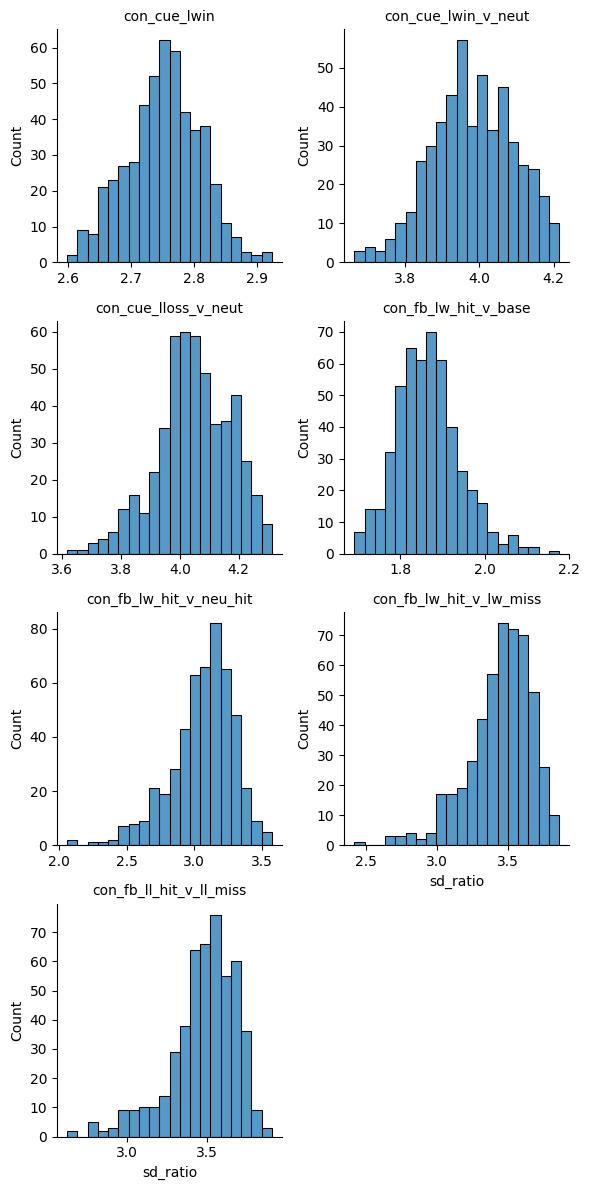

In [9]:
df = pd.DataFrame({'sd_ratio': sd_ratio, 'contrast_name': contrast_name})

g = sns.FacetGrid(
    df,
    col='contrast_name',
    col_wrap=2,
    sharex=False,
    sharey=False,
)
g.map_dataframe(sns.histplot, x='sd_ratio', bins=20)

g.set_titles(col_template='{col_name}')
plt.tight_layout()
plt.show()

In [10]:
# mean ratios
df.groupby('contrast_name').mean()

,sd_ratio
contrast_name,
con_cue_lloss_v_neut,4.046609
con_cue_lwin,2.752185
con_cue_lwin_v_neut,3.983456
con_fb_ll_hit_v_ll_miss,3.478167
con_fb_lw_hit_v_base,1.865853
con_fb_lw_hit_v_lw_miss,3.443782
con_fb_lw_hit_v_neu_hit,3.061851
